# 인간보다 퀴즈를 잘푸는 인공지능

|평가문항|상세기준|
|---|---|
|1. BERT pretrained model을 활용한 KorQuAD 모델이 정상적으로 학습이 진행되었다.|KorQuAD 모델의 validation accuracy가 안정적으로 증가하였다.|
|2. KorQuAD Inference 결과가 원래의 정답과 비교하여 유사하게 나오는 것을 확인하였다.|평가셋에 대해 모델 추론 결과와 실제 정답의 유사성이 확인되었다.|
|3. pretrained model 활용이 효과적임을 실험을 통해 확인하였다.|pretrained model을 사용하지 않았을 때 대비 학습경과의 차이를 시각화를 통해 확인하였다.|

# 라이브러리 및 패키지

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# 한국어 폰트 설치를 확인합니다.  
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# 데이터 확인

In [2]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

# 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
#     print_json_tree(train_json)

In [4]:
# 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
#     print_json_tree(dev_json)

In [5]:
# json file 형태로 확인
# print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

# 데이터 전처리

### KorQuAD dataset (1) 띄어쓰기 단위 정보관리

In [6]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [7]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

* 띄어쓰기 단위로 token을 정리 후, word token 영역별로 유니크한 숫자(어절 번호)를 부여.
 * word_token : 원래 데이터가 띄어쓰기 단위로 어떠했었는지 word token 영역별로 추가 정보를 관리
 * char_to_word : word_token 영역을 표시해 주는 list
   * 현재 글자가 몇 번째 어절에 포함된 것인지 확인

### KorQuAD dataset (2) Tokenize by Vocab

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")


def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

### KorQuAD dataset (3) Improve Span

In [9]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

* 질문(question)과 지문(context)을 주고, 지문에서 정답(answer)를 찾도록 구성.
* 정답에 해당하는 지문을 정확히 찾아내는 것이 Point

### KorQuAD dataset (4) 데이터셋 분리

In [10]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

* train, dev dataset을 분리해서 _improve_span() 함수를 이용하여 전처리 후 파일로 저장

In [11]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

### KorQuAD dataset (5) 데이터 로드

In [12]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [13]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [14]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [15]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

# train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


# BERT 구조 정의
* Transformer Encoder 구조를 활용
* Transformer의 Decoder를 대신하여 Encoder에 input을 했을 때 출력 모델이 Mask LM, NSP 2가지 문제를 해결하도록 되어 있음.


* Mask LM
 * Next Token Prediction Language Model과 대비 시켜 '다음 빈칸에 알맞은 말은?' 문제를 계속 풀어보도록 언어 모델을 구현한 것.


* Next Sentence Prediction
 * "입력데이터가 나는 밥을 먹었다. <SEP> 그래서 지금 배가 부르다."가 주어졌을 때 <SEP>를 경계로 좌우 두 문장이 순서대로 이어지는 문장이 맞는지를 맞추는 문제
 * BERT의 입력부분에서 실제 모델에 입력되는 것은 Token + Segment + Position Embedding 이 3가지가 더해진 형태  
 * 이후 Layer Nomalization과 dropout이 추가로 적용
    

* Token Embedding
 * 텍스트의 tokenizer로 Word Piece model이라는 subword tokenizer를 사용
 *  자주 등장하는 긴 길이의 subword도 하나의 단위로 만들어 줌
 * 자주 등장하지 않는 단어는 다시 subword 단위로 쪼개짐
    * 자주 등장하지 않는 단어가 OOV(Out-of-vocabulary) 처리되지 않도록 방지.
    * 최종적으로 Word Piece 모델의 각 임베딩이 입력
    

* Segment Embedding
 * 각 단어가 어느 문장에 포함되는지 그 역할을 규정하는 것.
 * QA 문제처럼 Question 문장에 속하는지, Context 문장에 속하는지 구분이 필요한 경우에 이 임베딩은 매우 유용하게 사용됨
    

* Position Embedding
 * Transformer에서 사용되던 position embedding과 동일

In [16]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [17]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [18]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [19]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [21]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

# BERT 모델 구현

In [23]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [24]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [25]:
config = Config({"d_model": 512, 
                 "n_head": 8, 
                 "d_head": 64, 
                 "dropout": 0.1, 
                 "d_ff": 1024, 
                 "layernorm_epsilon": 0.001, 
                 "n_layer": 6, 
                 "n_seq": 384, 
                 "n_vocab": 0, 
                 "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
# config

* BERT-base(110M parameters) : 12-layer, 768-hidden, 12-heads
* BERT-large (336M parameters) : 24-layer, 1024-hidden, 16-heads
* Tiny Bert(29M parameters) : 6-layer, 512-hidden, 8-heads


* 시간이 많이 소요되기 때문에 __Tiny Bert(29M parameters)__ 사용

In [26]:
bert_batch_size = 16 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [27]:
model = BERT4KorQuAD(config)

In [28]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [29]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [30]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(3):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0109, 0.0058
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0060, 0.0067


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0035, 0.0028


# pretrained model 로딩

In [31]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_73 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


# pretrained model finetune 하기

In [32]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

for epoch in range(3):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 2.0022, 2.2463, acc: 0.5132, 0.4817
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 1.7301, 1.9637, acc: 0.5548, 0.5223
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 1.8192, 2.0517, acc: 0.5564, 0.5170


# Inference 수행하기

In [33]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [34]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

# 학습 경과 시각화 비교분석

* pretrain을 하지 않은 tiny bert는 시각화에 필요한 코드를 넣고 돌리는 시간까지 고려하지 못하여 결과 값을 dataframe으로 만들어서 시각화 하였다.

* 초기 시각화 접근은 Tensorboard를 사용하려고 했으나 외부(내 pc)에서 클라우드 컨테이너로 접근하려고 보니 방화벽 문제로 방화벽을 뚫어서 해볼까 했으나 혹시나 일 생길까 싶어서 다른 방법을 찾았다.  

학습을 진행하면서 부주의 및 lms 오류 때문에 자주 멈췄고 끝까지 다 돌리지 못했다. 가장 많이 돌아갔던 것을 바탕으로 설명하자면 epoch이 진행됨에 따라 loss는 떨어지고 acc는 증가 했지만 더 이상의 진전은 없었기 때문에 학습과정을 3epoch으로 줄였고 시각화 데이터는 가장 많이 돌았던 순서를 기준으로 백업을 하였기 때문에 그대로 사용하였다.

* __사전 학습 되지 않은 Tiny Bert__

|epoch|start_loss|end_loss|start_acc|end_acc| 
|---|---|---|---|---|
|0|5.9507|5.9507|0.0162|0.0095|
|1|5.9507|5.9507|0.0160|0.0067|
|2|5.9507|5.9507|0.0049|0.0033|
|3|5.9507|5.9507|0.0035|0.0032|
|4|5.9507|5.9507|0.0028|0.0030|
|5|5.9507|5.9507|0.0000|0.0000|

In [39]:
npt_df = pd.DataFrame({"epoch":[0,1,2,3,4,5],
                      "start_loss":[5.9507,5.9507,5.9507,5.9507,5.9507,5.9507],
                      "end_loss":[5.9507,5.9507,5.9507,5.9507,5.9507,5.9507],
                      "start_acc":[0.0162,0.0160,0.0049,0.0035,0.0028,0.0000],
                      "end_acc":[0.0095,0.0067,0.0033,0.0032,0.0030,0.0000]})

* __사전 학습 된 bert__

|epoch|start_loss|end_loss|start_acc|end_acc| 
|---|---|---|---|---|
|0|1.9499|2.2324|0.4975|0.4482|
|1|1.8255|2.1402|0.5360|0.4758|
|2|1.8308|2.1226|0.5544|0.5033|
|3|2.2068|2.5307|0.5293|0.4807|

In [40]:
pt_df = pd.DataFrame({"epoch":[0,1,2,3],
                      "start_loss":[1.9499,1.8255,1.8308,2.2068],
                      "end_loss":[2.2324,2.1402,2.1226,2.5307],
                      "start_acc":[0.4975,0.5360,0.5544,0.5293],
                      "end_acc":[0.4482,0.4758,0.5033,0.4807]})

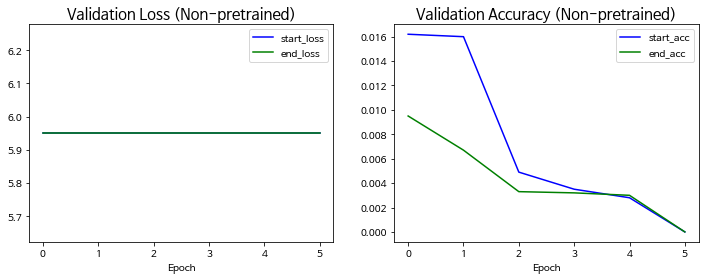

In [43]:
# Non pretrained model

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(npt_df['start_loss'], 'b-', label='start_loss')
plt.plot(npt_df['end_loss'], 'g-', label='end_loss')
plt.title('Validation Loss (Non-pretrained)', fontsize=15)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(npt_df['start_acc'], 'b-', label='start_acc')
plt.plot(npt_df['end_acc'], 'g-', label='end_acc')
plt.title('Validation Accuracy (Non-pretrained)', fontsize=15)
plt.xlabel('Epoch')
plt.legend()

plt.show()

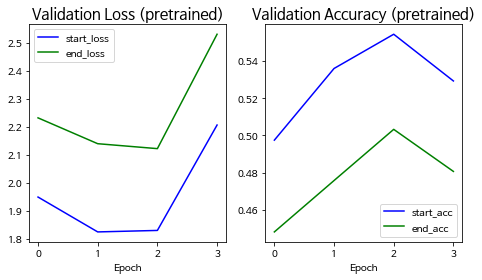

In [44]:
# pretrained model

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(pt_df['start_loss'], 'b-', label='start_loss')
plt.plot(pt_df['end_loss'], 'g-', label='end_loss')
plt.title('Validation Loss (pretrained)', fontsize=15)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(pt_df['start_acc'], 'b-', label='start_acc')
plt.plot(pt_df['end_acc'], 'g-', label='end_acc')
plt.title('Validation Accuracy (pretrained)', fontsize=15)
plt.xlabel('Epoch')
plt.legend()

plt.show()

실제 basic한 모델 및 Large 모델에 비해서 Tiny한 모델이지만 적은 epoch으로 이정도가 나올 수 있다는게 신기했다. 하지만 적은 epoch으로 시각화 그래프는 변동이 심한 것 처럼 보일 수 있다. 